# NLA Assignment: Project A (SVD)

## Preprocessing

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def load_data():
    """Loads training and test data from text files."""
    print("Loading data...")
    # Training data
    train_labels = np.loadtxt('dzip.txt', delimiter=',', dtype=np.int32)
    train_images = np.loadtxt('azip.txt', delimiter=',').T

    test_labels = np.loadtxt('dtest.txt', delimiter=',', dtype=np.int32)
    test_images = np.loadtxt('testzip.txt', delimiter=',').T

    # Normalize to [0, 1]
    train_images = (train_images + 1) / 2
    test_images = (test_images + 1) / 2

    print(f"Training data shape: {train_images.shape}")
    print(f"Test data shape: {test_images.shape}")
    return train_images, train_labels, test_images, test_labels

def map_data(images, labels):
    """Maps images to their corresponding labels."""
    image_map = {key: [] for key in range(10)}
    for i in range(len(labels)):
        label = labels[i]
        image_map[label].append(images[i])

    image_map = {key: np.array(value) for key, value in image_map.items()}
    return image_map

train_images, train_labels, test_images, test_labels = load_data()

train_map = map_data(train_images, train_labels)
test_map = map_data(test_images, test_labels)

Loading data...
Training data shape: (1707, 256)
Test data shape: (2007, 256)


## SVD Classification (Task 1)

In [3]:
svd_map = {key: {} for key in range(10)}

for label, images in train_map.items():
    U, S, Vt = np.linalg.svd(images.T, full_matrices=False)
    
    svd_map[label]['vectors'] = U
    svd_map[label]['s_values'] = S

k_accuracy_scores = {i: {} for i in range(20, 4, -1)}

for i in range(20, 4, -1):
    accuracy_scores = [0 for _ in range(10)]
    test_pred = {key: [] for key in range(10)}
    total_correct = 0
    for label, images in test_map.items():
        correct_count = 0
        for image in images:
            residual_norm = []
            for j in range(10):
                projection = svd_map[j]['vectors'][:, :i] @ svd_map[j]['vectors'][:, :i].T @ image
                residual_norm.append(np.linalg.norm(image - projection))
            residual_norm = np.array(residual_norm)
            predicted_label = np.argmin(residual_norm)
            test_pred[label].append(predicted_label)
            if predicted_label == label:
                correct_count += 1
        accuracy_scores[label] = correct_count / len(images)
        total_correct += correct_count
    k_accuracy_scores[i]['accuracy_macro'] = accuracy_scores
    score = total_correct / test_images.shape[0]
    k_accuracy_scores[i]['accuracy'] = score
    print(f"Accuracy for k={i}: {score:.4f}")
max_k = max(k_accuracy_scores, key=lambda k: k_accuracy_scores[k]['accuracy'])
print(f"Best k value: {max_k} with accuracy {k_accuracy_scores[max_k]['accuracy']:.4f}")

Accuracy for k=20: 0.9397
Accuracy for k=19: 0.9382
Accuracy for k=18: 0.9382
Accuracy for k=17: 0.9387
Accuracy for k=16: 0.9377
Accuracy for k=15: 0.9382
Accuracy for k=14: 0.9387
Accuracy for k=13: 0.9327
Accuracy for k=12: 0.9337
Accuracy for k=11: 0.9312
Accuracy for k=10: 0.9322
Accuracy for k=9: 0.9258
Accuracy for k=8: 0.9248
Accuracy for k=7: 0.9248
Accuracy for k=6: 0.9128
Accuracy for k=5: 0.9093
Best k value: 20 with accuracy 0.9397


## Dangerous Classes (Task 2)

Confusion matrix: 
[[356   0   9   2   1   7   3   0   4   0]
 [  0 259   1   0   1   1   0   1   0   1]
 [  1   0 179   4   1   2   0   1   1   0]
 [  0   0   1 148   0   3   0   0   5   1]
 [  1   3   2   1 183   0   2   3   0   4]
 [  0   0   0   8   1 142   2   0   2   0]
 [  0   2   0   0   2   0 163   0   0   0]
 [  0   0   1   0   4   0   0 140   0   3]
 [  0   0   5   3   0   2   0   0 150   2]
 [  1   0   0   0   7   3   0   2   4 166]]
The most difficult digit is 0, often mistaken for 2. It was confused 9 times.


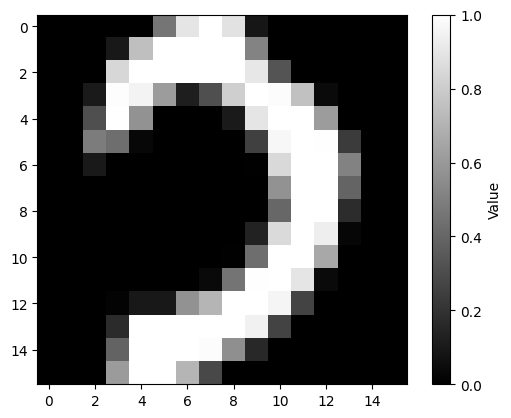

In [4]:
confusion_matrix = [[0 for _ in range(10)] for _ in range(10)]
test_pred = {key: [] for key in range(10)}

for label, images in test_map.items():
    correct_count = 0
    for image in images:
        residual_norm = []
        for j in range(10):
            projection = svd_map[j]['vectors'][:, :max_k] @ svd_map[j]['vectors'][:, :max_k].T @ image
            residual_norm.append(np.linalg.norm(image - projection))
        residual_norm = np.array(residual_norm)
        predicted_label = np.argmin(residual_norm)
        confusion_matrix[predicted_label][label] += 1
        test_pred[label].append(predicted_label)
        if predicted_label == label:
            correct_count += 1

confusion_matrix = np.array(confusion_matrix)
print(f"Confusion matrix: \n{confusion_matrix}")

cm_no_diag = confusion_matrix.copy()
np.fill_diagonal(cm_no_diag, 0)

max_error_idx = np.argmax(cm_no_diag)

true_label, pred_label = np.unravel_index(max_error_idx, cm_no_diag.shape)

print(f"The most difficult digit is {true_label}, often mistaken for {pred_label}. It was confused {cm_no_diag[true_label, pred_label]} times.")

example_i = test_pred[true_label].index(pred_label)

example = test_map[true_label][example_i]

image_matrix = example.reshape((16, 16))
plt.imshow(image_matrix, cmap='gray')
plt.colorbar(label="Value")

plt.show()

As we can see, this picture is a very poorly drawn 0, which the model very understandably classified as a 2. That means that the given dataset also had poorly drawn numbers

## Singular Values (Task 3)

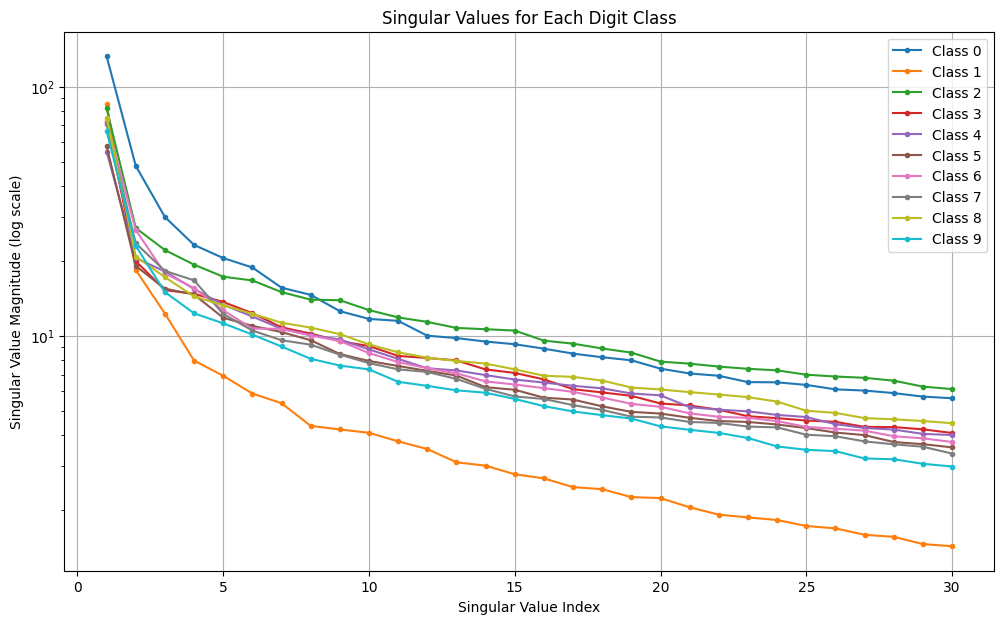

In [5]:
plt.figure(figsize=(12, 7))
for label, val in svd_map.items():
    # Plot the first 30 singular values for each class
    plt.plot(range(1, len(val['s_values'][:30]) + 1), val['s_values'][:30], marker='.', linestyle='-', label=f'Class {label}')

plt.title('Singular Values for Each Digit Class')
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Value Magnitude (log scale)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()


This plot leads us to believe that classes with a very rapid drop in Singular Values (Class 1) will have little to no accuracy drop, even for lower k values. The following code block will conduct such an experiment.

In [8]:
baseline_k = max_k
baseline_accuracy = k_accuracy_scores[baseline_k]['accuracy']
print(f"Baseline accuracy with k={baseline_k} for all classes: {baseline_accuracy:.4f}\n")

target_class = 1
k_values_for_target = range(15, 4, -1) # Test from k=15 down to k=5

for k_target in k_values_for_target:
    k_values_hybrid = {i: baseline_k for i in range(10)}
    k_values_hybrid[target_class] = k_target
    
    total_correct = 0
    
    # Run the classification using the hybrid k values
    for label, images in test_map.items():
        for image in images:
            residual_norm = []
            for j in range(10):
                # Use the specific k for the current class j
                k_j = k_values_hybrid[j]
                
                projection = svd_map[j]['vectors'][:, :k_j] @ svd_map[j]['vectors'][:, :k_j].T @ image
                residual_norm.append(np.linalg.norm(image - projection))
            
            predicted_label = np.argmin(residual_norm)
            if predicted_label == label:
                total_correct += 1

    accuracy = total_correct / test_images.shape[0]
    print(f"  - Using k={k_target} for Class {target_class}: Accuracy = {accuracy:.4f}")

Baseline accuracy with k=20 for all classes: 0.9397

  - Using k=15 for Class 1: Accuracy = 0.9397
  - Using k=14 for Class 1: Accuracy = 0.9397
  - Using k=13 for Class 1: Accuracy = 0.9397
  - Using k=12 for Class 1: Accuracy = 0.9397
  - Using k=11 for Class 1: Accuracy = 0.9392
  - Using k=10 for Class 1: Accuracy = 0.9392
  - Using k=9 for Class 1: Accuracy = 0.9382
  - Using k=8 for Class 1: Accuracy = 0.9382
  - Using k=7 for Class 1: Accuracy = 0.9372
  - Using k=6 for Class 1: Accuracy = 0.9362
  - Using k=5 for Class 1: Accuracy = 0.9347


As we can see, up until a k of 12, Class 1 accuracy is (almost) completely unaffected. That confirms the theory that lower variance gives us the opportunity to use fewer basis vectors.

## Optional Task: Two-Stage Algorithm

In [6]:
# Test a range of thresholds for the two-stage classification
thresholds = np.round(np.arange(1.1, 2.0, 0.1), 2)
best_accuracy_2stage = 0
best_threshold = 0
best_stage1_freq = 0

k_stage1 = 1
k_stage2 = max_k

original_accuracy = k_accuracy_scores[max_k]['accuracy']

for T in thresholds:
    total_correct = 0
    stage1_count = 0

    for label, images in test_map.items():
        for image in images:
            residual_norm_s1 = []
            for j in range(10):
                projection_s1 = svd_map[j]['vectors'][:, :k_stage1] @ svd_map[j]['vectors'][:, :k_stage1].T @ image
                residual_norm_s1.append(np.linalg.norm(image - projection_s1))

            sorted_indices = np.argsort(residual_norm_s1)
            min_idx, second_min_idx = sorted_indices[0], sorted_indices[1]
            
            min_residual = residual_norm_s1[min_idx]
            second_min_residual = residual_norm_s1[second_min_idx]

            predicted_label = -1

            # Add a small epsilon to avoid division by zero in case of a perfect match
            if min_residual > 1e-9 and (second_min_residual / min_residual) > T:
                predicted_label = min_idx
                stage1_count += 1
            else:
                residual_norm_s2 = []
                for j in range(10):
                    projection_s2 = svd_map[j]['vectors'][:, :k_stage2] @ svd_map[j]['vectors'][:, :k_stage2].T @ image
                    residual_norm_s2.append(np.linalg.norm(image - projection_s2))
                predicted_label = np.argmin(residual_norm_s2)

            if predicted_label == label:
                total_correct += 1

    accuracy = total_correct / test_images.shape[0]
    stage1_freq = stage1_count / test_images.shape[0]

    print(f"Threshold T = {T:.2f}: Accuracy = {accuracy:.4f}, Stage 1 used {stage1_freq*100:.2f}% of the time.")

    if accuracy >= best_accuracy_2stage:
        best_accuracy_2stage = accuracy
        best_threshold = T
        best_stage1_freq = stage1_freq

print("\n--- Summary ---")
print(f"Best accuracy of {best_accuracy_2stage:.4f} achieved with threshold T = {best_threshold:.2f}.")
print(f"At this threshold, the second stage was unnecessary {best_stage1_freq*100:.2f}% of the time.")
print(f"The original accuracy with k={max_k} was {original_accuracy:.4f}.")

Threshold T = 1.10: Accuracy = 0.9173, Stage 1 used 66.07% of the time.
Threshold T = 1.20: Accuracy = 0.9372, Stage 1 used 46.99% of the time.
Threshold T = 1.30: Accuracy = 0.9392, Stage 1 used 34.28% of the time.
Threshold T = 1.40: Accuracy = 0.9397, Stage 1 used 24.86% of the time.
Threshold T = 1.50: Accuracy = 0.9397, Stage 1 used 19.48% of the time.
Threshold T = 1.60: Accuracy = 0.9397, Stage 1 used 16.04% of the time.
Threshold T = 1.70: Accuracy = 0.9397, Stage 1 used 14.10% of the time.
Threshold T = 1.80: Accuracy = 0.9397, Stage 1 used 12.61% of the time.
Threshold T = 1.90: Accuracy = 0.9397, Stage 1 used 11.46% of the time.

--- Summary ---
Best accuracy of 0.9397 achieved with threshold T = 1.90.
At this threshold, the second stage was unnecessary 11.46% of the time.
The original accuracy with k=20 was 0.9397.


We see that even though the program detected the "best" accuracy to be with a threshold of 1.90, in reality that very same accuracy is achieved from the threshold of 1.40, skipping the need for the best k for around 1 in 4 images.